In [8]:
import gym
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def get_epsilon_greedy_action(q_values, epsilon, action_n):
    policy = np.ones(action_n) * epsilon / action_n
    max_action = np.argmax(q_values)
    policy[max_action] += 1 - epsilon
    return np.random.choice(np.arange(action_n), p=policy)


def MonteCarlo(env, episode_n, trajectory_len=500, gamma=0.99, estrategy='default'):
    total_rewards = []

    state_n = env.observation_space.n
    action_n = env.action_space.n
    qfunction = np.zeros((state_n, action_n))
    counter = np.zeros((state_n, action_n))

    for episode in range(episode_n):
        epsilon = episode / episode_n
        if estrategy == 'default':
            epsilon = 1 - epsilon
        elif estrategy == 'exp':
            epsilon = np.power(epsilon + 1, -7)
        elif estrategy == 'log':
            epsilon = (np.log(epsilon + 1)/np.log(100)) + 1
        elif estrategy == 'sigmoid':
            epsilon = 1/(1 + np.exp(10 * (epsilon - 0.5)))
        trajectory = {'states': [], 'actions': [], 'rewards': []}

        state = env.reset()
        for _ in range(trajectory_len):
            trajectory['states'].append(state)

            action = get_epsilon_greedy_action(qfunction[state], epsilon, action_n)
            trajectory['actions'].append(action)

            state, reward, done, _ = env.step(action)
            trajectory['rewards'].append(reward)

            if done:
                break

        total_rewards.append(sum(trajectory['rewards']))

        real_trajectory_len = len(trajectory['rewards'])
        returns = np.zeros(real_trajectory_len + 1)
        for t in range(real_trajectory_len - 1, -1, -1):
            returns[t] = trajectory['rewards'][t] + gamma * returns[t + 1]

        for t in range(real_trajectory_len):
            state = trajectory['states'][t]
            action = trajectory['actions'][t]
            qfunction[state][action] += (returns[t] - qfunction[state][action]) / (1 + counter[state][action])
            counter[state][action] += 1

    return np.array(total_rewards)


In [15]:
env = gym.make("Taxi-v3")

result = {}
for method in ['default', 'exp', 'log', 'sigmoid']:
    total_rewards = MonteCarlo(env, episode_n=1500, trajectory_len=1000, gamma=0.99)
    result[method] = total_rewards
result.keys(), result[list(result.keys())[0]].shape

/Users/m.averchenko/PycharmProjects/drl_ods_2022/venv/lib/python3.9/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/m.averchenko/PycharmProjects/drl_ods_2022/venv/lib/python3.9/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/Users/m.averchenko/PycharmProjects/drl_ods_2022/venv/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


(dict_keys(['default', 'exp', 'log', 'sigmoid']), (1500,))

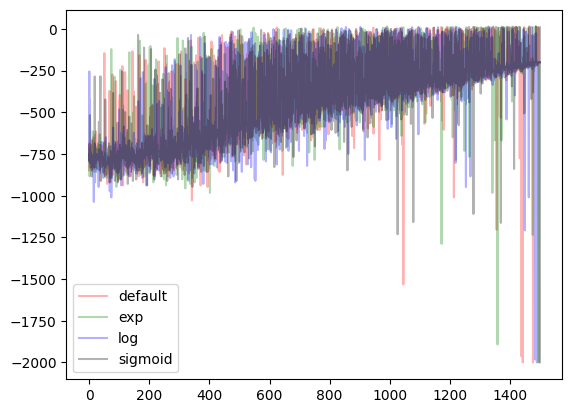

In [30]:
color_map = {
    'default': 'red',
    'exp': 'green',
    'log': 'blue',
    'sigmoid': 'black'
}

for key in result:
    plt.plot(result[key], color=color_map[key], label=key, alpha=0.3)
plt.legend()
plt.show()